# Урок 3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация
## Домашнее задание
Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
dataset = fetch_california_housing(as_frame=True)

In [3]:
dataset['data']

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


Посмотрим распределения фитчей:

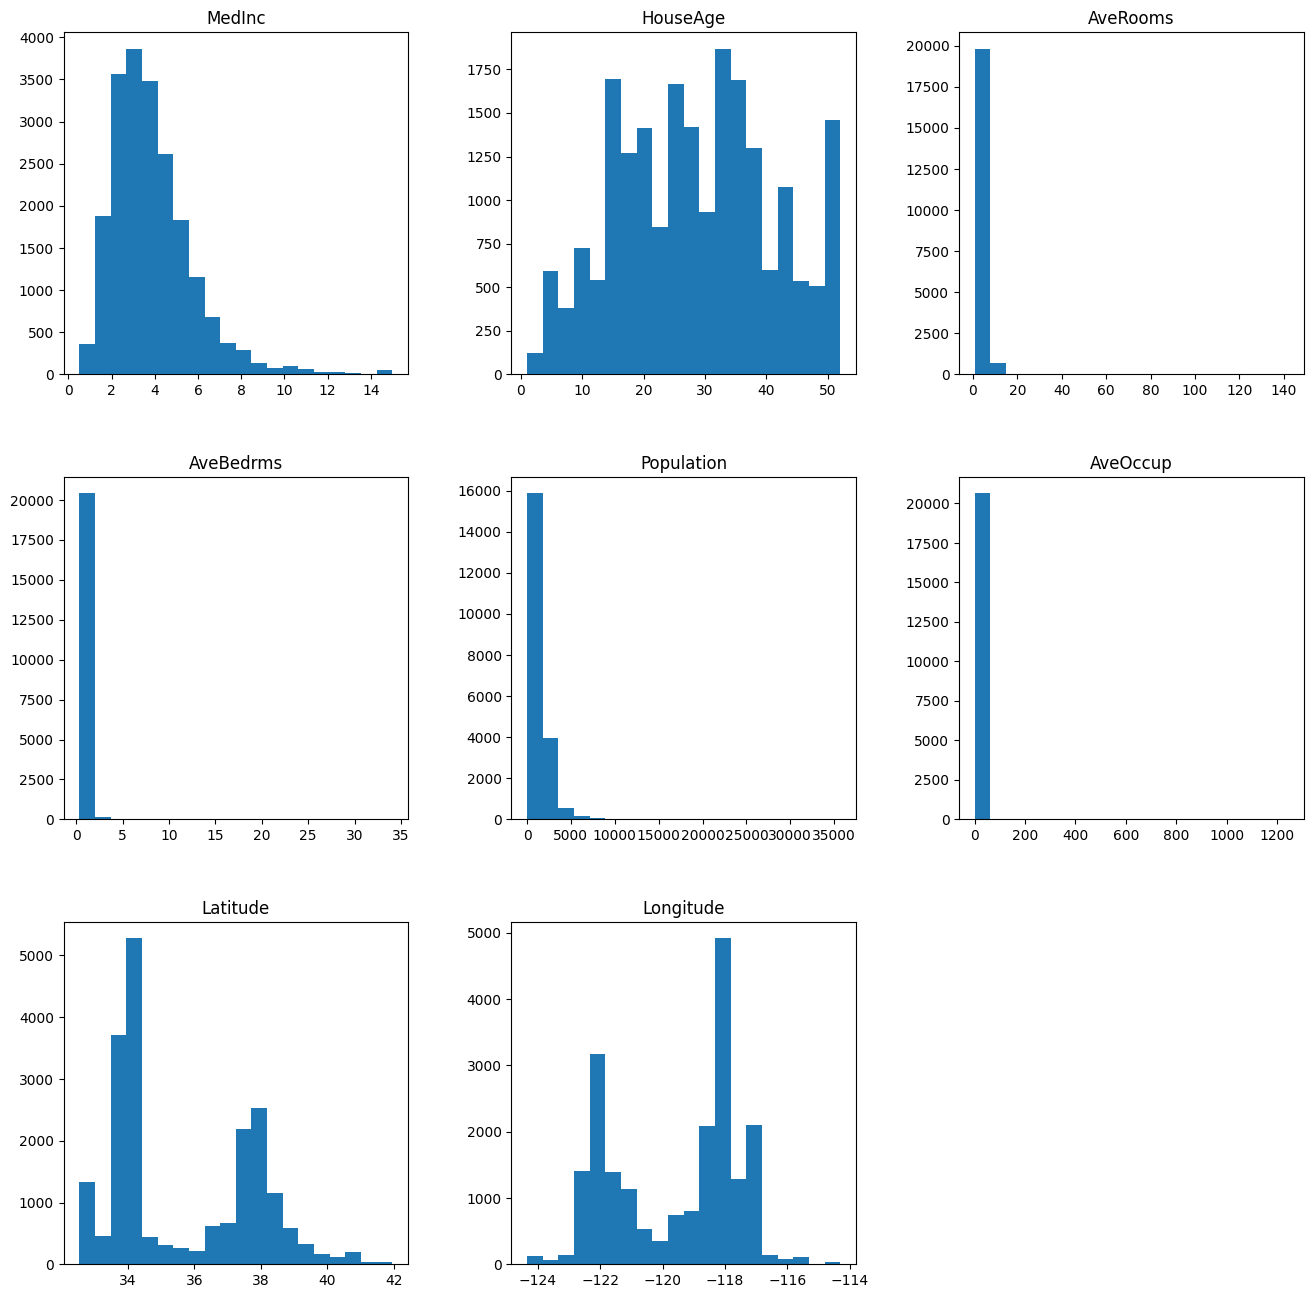

In [4]:
dataset['data'].hist(figsize=(16,16), bins=20, grid=False)
plt.show()

У 4-х фитчей распределение с очень длинным хвостом. Применим для них логарифмирование.

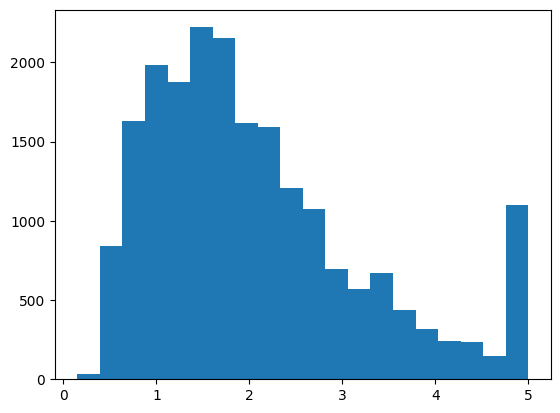

In [5]:
y = dataset['target']
y.hist(bins=20, grid=False)
plt.show()

In [6]:
dataset['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

<ipython-input-7-22ab773b9709>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i] = np.log(X[i] + 1)


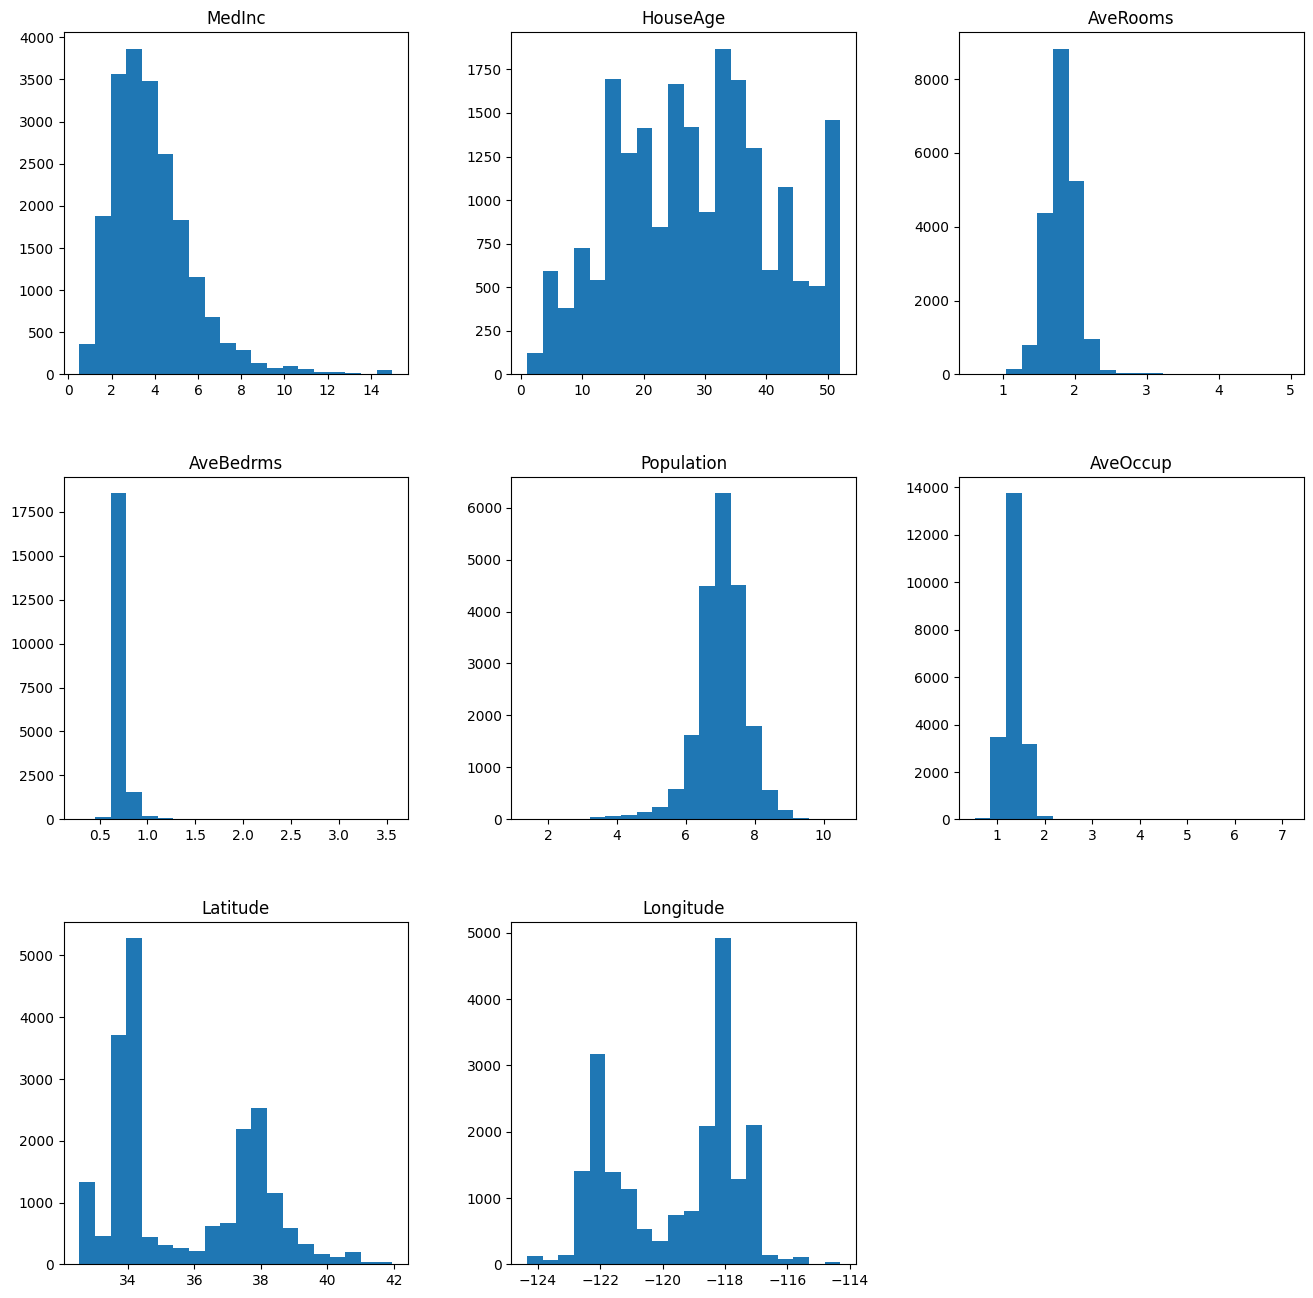

In [7]:
X = dataset['data']
prep_cols = ['AveRooms',
            'AveBedrms',
            'Population',
            'AveOccup']
for i in prep_cols:
  X[i] = np.log(X[i] + 1)
dataset['data'].hist(figsize=(16,16), bins=20, grid=False)
plt.show()

После логарифмирования распределение 4-х фичей стало намного лучше.
Разобьем выборку на тренировочную и тестовую, а потом проведем стандартизацию.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7
count,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04
mean,-1.055716e-16,-5.967090e-18,-5.872994e-16,9.235220e-16,-3.396651e-16,-4.479908e-16,-1.760751e-15,3.795987e-16
std,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00
min,-1.770818e+00,-2.205284e+00,-4.639948e+00,-4.231102e+00,-7.171006e+00,-3.952088e+00,-1.449211e+00,-2.367473e+00
25%,-6.877530e-01,-8.528508e-01,-5.802782e-01,-3.383509e-01,-4.853545e-01,-5.700157e-01,-8.021129e-01,-1.109468e+00
50%,-1.783232e-01,2.225275e-02,3.406177e-03,-1.417095e-01,4.693957e-02,-5.484873e-02,-6.484853e-01,5.363810e-01
75%,4.626776e-01,6.586917e-01,5.393808e-01,9.266408e-02,5.851758e-01,4.890473e-01,9.669320e-01,7.849986e-01
max,5.866520e+00,1.852015e+00,1.356998e+01,2.691051e+01,4.722328e+00,2.764048e+01,2.931503e+00,2.624769e+00


In [11]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7
count,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000
mean,0.018345,-0.025711,0.012539,0.004871,-0.034147,-0.002135,-0.039326,0.037834
std,1.002460,1.004714,1.016673,1.015951,1.029463,0.973150,0.976677,0.984272
min,-1.770818,-2.205284,-5.260045,-3.468721,-7.725892,-3.791629,-1.439900,-2.327694
25%,-0.671557,-0.852851,-0.580771,-0.347076,-0.523808,-0.571618,-0.802113,-1.029910
50%,-0.150355,0.022253,0.010736,-0.135699,0.028712,-0.062725,-0.657796,0.556270
75%,0.467734,0.658692,0.560644,0.095535,0.557303,0.499915,0.939000,0.789971
max,5.866520,1.852015,9.179350,16.839997,3.635140,14.747873,2.889604,2.545211


На тесте среднее и дисперсия практически соответствуют нормальному распределению

In [12]:
class MyOwnCalifornia(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, init_target):
        self._base_dataset = init_dataset.astype('float32')
        self._base_target = np.array(init_target.astype('float32')).reshape(-1, 1)

    def __len__(self):
        return self._base_dataset.shape[0]

    def __getitem__(self, idx):
        feats, target = self._base_dataset[idx], self._base_target[idx]
        return feats, target

In [13]:
dataset = MyOwnCalifornia(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset,
                          batch_size=2048,
                          shuffle=True,
                          num_workers=2)

In [14]:
test_dataset = MyOwnCalifornia(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=512,
                          shuffle=False,
                          num_workers=2)

Соберем сеть. Так как данные стадартизированы, применим leaky_relu, а на выходном слое возьмем relu, так как у цены не может быть отрицательных значений.

In [15]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        if self.activation == "leaky_relu":
            return F.leaky_relu(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, bn_dp):
        super().__init__()
        self.bn_dp = bn_dp
        self.fc1 = Perceptron(input_dim, hidden_dim, activation="leaky_relu")
        if bn_dp:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
            self.dp1 = nn.Dropout(0.2)
        self.fc2 = Perceptron(hidden_dim, int(hidden_dim / 2), activation="leaky_relu")
        if bn_dp == 2:
            self.bn2 = nn.BatchNorm1d(int(hidden_dim / 2))
            self.dp2 = nn.Dropout(0.2)
        self.fc3 = Perceptron(int(hidden_dim / 2), 1, "relu")
        
    def forward(self, x):
        x = self.fc1(x)
        if self.bn_dp:
            x = self.dp1(x)
            x = self.bn1(x)
        x = self.fc2(x)
        if self.bn_dp == 2:
            x = self.dp2(x)
            x = self.bn2(x)
        x = self.fc3(x)
        return x

In [16]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [17]:
num_epochs = 120
def learn_net(num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):  
        running_loss, r2 = 0.0, 0.0
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]

            # обнуляем градиент
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            r2 += r2_loss(outputs, target).item()
            

        net.eval()
        train_losses.append(running_loss / (i + 1))
        print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
              f'Loss: {running_loss / (i + 1):.3f}. ' \
              f'R2: {r2 / (i + 1):.3f}', end='. ')
        running_loss, r2 = 0.0, 0.0

        test_running_loss, test_r2 = 0.0, 0.0
        for j, data in enumerate(test_loader):
        
            test_outputs = net(data[0])
            test_running_loss += criterion(test_outputs, data[1]).item()
            test_r2 += r2_loss(outputs, target).item()
        test_losses.append(test_running_loss / (j + 1))
        print(f'Test Loss: {test_running_loss / (j + 1):.3f}. ' \
              f'Test R2: {test_r2 / (j + 1):.3f}')
        net.train()
            
    print('Training is finished!')
    return train_losses, test_losses

Проведем три эксперимента - в первом не будет связки слоев dropout+batch_norm, во втором будет одна связка после первого слоя, а в третьем эта связка будет после двух слоев.

In [18]:
train_mse = []
test_mse = []
for i in range(3):
    net = FeedForward(8, 300, i)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_losses, test_losses = learn_net(num_epochs)
    train_mse.append(train_losses)
    test_mse.append(test_losses)

Epoch [1/120]. Loss: 3.469. R2: -1.608. Test Loss: 1.540. Test R2: -0.362
Epoch [2/120]. Loss: 1.428. R2: -0.078. Test Loss: 1.066. Test R2: 0.254
Epoch [3/120]. Loss: 0.842. R2: 0.362. Test Loss: 0.721. Test R2: 0.442
Epoch [4/120]. Loss: 0.702. R2: 0.471. Test Loss: 0.643. Test R2: 0.469
Epoch [5/120]. Loss: 0.630. R2: 0.522. Test Loss: 0.623. Test R2: 0.568
Epoch [6/120]. Loss: 0.584. R2: 0.560. Test Loss: 0.571. Test R2: 0.610
Epoch [7/120]. Loss: 0.541. R2: 0.592. Test Loss: 0.532. Test R2: 0.628
Epoch [8/120]. Loss: 0.504. R2: 0.620. Test Loss: 0.498. Test R2: 0.630
Epoch [9/120]. Loss: 0.473. R2: 0.643. Test Loss: 0.468. Test R2: 0.648
Epoch [10/120]. Loss: 0.445. R2: 0.665. Test Loss: 0.446. Test R2: 0.675
Epoch [11/120]. Loss: 0.420. R2: 0.681. Test Loss: 0.424. Test R2: 0.686
Epoch [12/120]. Loss: 0.400. R2: 0.698. Test Loss: 0.409. Test R2: 0.712
Epoch [13/120]. Loss: 0.387. R2: 0.708. Test Loss: 0.395. Test R2: 0.685
Epoch [14/120]. Loss: 0.373. R2: 0.719. Test Loss: 0.387.

Отрисуем эксперимент:

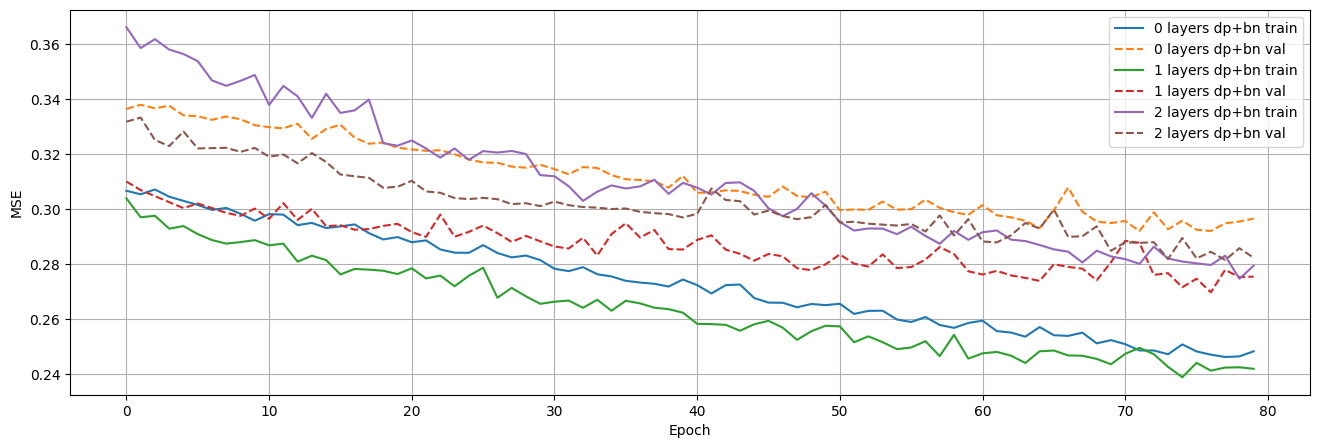

In [19]:
plt.figure(figsize = (16,5))
for i in range(3):
    plt.plot(train_mse[i][40:],'-',label = f'{i} layers dp+bn train')
    plt.plot(test_mse[i][40:],'--',label = f'{i} layers dp+bn val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid()
plt.show() 

Без нормализации и дропаута сеть сильно переобучается, и метрика на тесте хуже других примеров. При нормализации и регуляризации дропаутом после первого слоя результат не сильно лучше - сеть сильно переобучатся, но метрика чуть лучше.
При нормализации и дропауте после двух слоев обучение идет медленнее, но сеть не переобучается, а также видно, что у сети еще есть потенциал дообучиться. Есть возможность достигнуть лучшей метрики на тесте. Также еще одно наблюдение при применении дропаута - с ним обучение идет менее плавно, со скачками функции потерь, но зато сеть не переобучается.

Теперь попробуем разные оптимизаторы:

In [20]:
train_mse = []
test_mse = []
for i in range(3):
    net = FeedForward(8, 300, 2)
    if i == 0:
      optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    elif i == 1:
      optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, alpha=0.99)
    else:
      optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    train_losses, test_losses = learn_net(num_epochs)
    train_mse.append(train_losses)
    test_mse.append(test_losses)

Epoch [1/120]. Loss: 3.205. R2: -1.429. Test Loss: 3.714. Test R2: -0.603
Epoch [2/120]. Loss: 1.789. R2: -0.348. Test Loss: 2.262. Test R2: -0.186
Epoch [3/120]. Loss: 1.402. R2: -0.055. Test Loss: 1.377. Test R2: 0.104
Epoch [4/120]. Loss: 1.224. R2: 0.077. Test Loss: 1.058. Test R2: 0.099
Epoch [5/120]. Loss: 1.084. R2: 0.179. Test Loss: 0.958. Test R2: 0.248
Epoch [6/120]. Loss: 1.021. R2: 0.227. Test Loss: 0.906. Test R2: 0.219
Epoch [7/120]. Loss: 0.973. R2: 0.262. Test Loss: 0.881. Test R2: 0.165
Epoch [8/120]. Loss: 0.920. R2: 0.306. Test Loss: 0.841. Test R2: 0.362
Epoch [9/120]. Loss: 0.894. R2: 0.325. Test Loss: 0.799. Test R2: 0.277
Epoch [10/120]. Loss: 0.849. R2: 0.358. Test Loss: 0.769. Test R2: 0.325
Epoch [11/120]. Loss: 0.820. R2: 0.381. Test Loss: 0.729. Test R2: 0.443
Epoch [12/120]. Loss: 0.771. R2: 0.417. Test Loss: 0.698. Test R2: 0.453
Epoch [13/120]. Loss: 0.754. R2: 0.430. Test Loss: 0.657. Test R2: 0.411
Epoch [14/120]. Loss: 0.708. R2: 0.464. Test Loss: 0.61

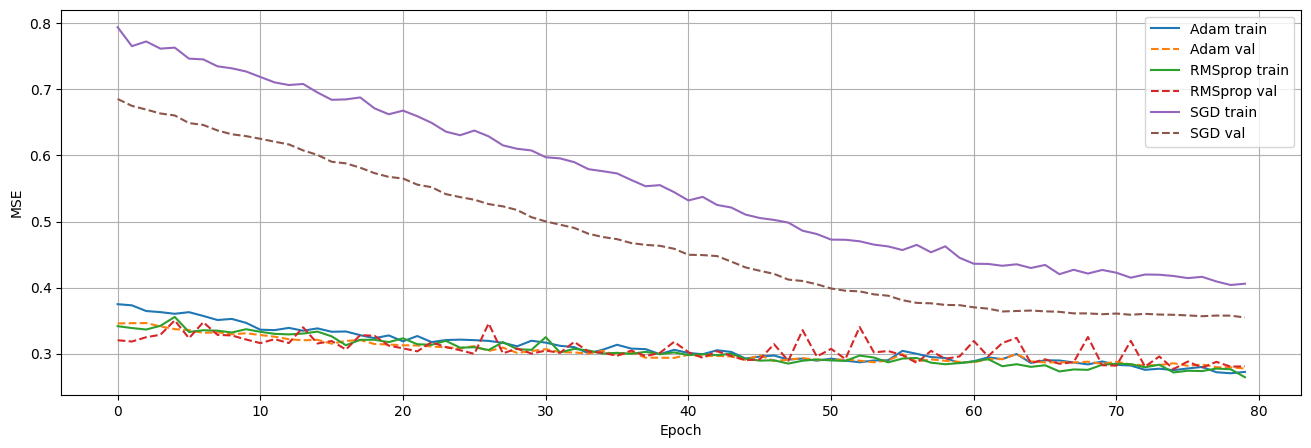

In [21]:
plt.figure(figsize = (16,5))
optims_label = ['Adam', 'RMSprop', 'SGD']
for i in range(3):
    plt.plot(train_mse[i][40:],'-',label = f'{optims_label[i]} train')
    plt.plot(test_mse[i][40:],'--',label = f'{optims_label[i]} val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid()
plt.show()

**SGD.** Обучение идет очень плавно, но явно не дообучается. Видимо, та самая седловая точка, или локальный минимум, из которого оптимизатор выпрыгнуть не смог.

**RMSprop.** Сходится быстрее всех, но наблюдаем сильные скачки функции потерь.

**Adam.** Показал себя лучше всех. Обучение довольно плавное, без скачков, сходится чуть медлееннее RMSprop, но зато сходится гарантированно.